In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [16]:
Train_dir = 'C:/Users/Hrishikesh M Rao/Documents/archive (1)/ck/CK+48'
emotions_loc = 'C:/Users/Hrishikesh M Rao/Documents/archive (1)/ck/CK+48'

In [17]:
images = []
labels = []
i=0
for emotions in os.listdir(Train_dir):
    emotion_path = os.path.join(emotions_loc,emotions)
    for filename in os.listdir(emotion_path):
        if filename.endswith('.png'):
            image_path = os.path.join(emotion_path, filename)
            image = Image.open(image_path)
            desired_size = (224, 224)
            image = image.resize(desired_size)
            image = np.array(image)
            image = image / 255.0
            images.append(image)
            label = np.zeros(7)
            label[i] = 1
            labels.append(label)
    i+=1       

The shape of the images list is = (981, 224, 224)
The size of the images list is = 49222656
Labels contains these Y0 values [array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0., 0., 0.]), array([1., 0., 0., 0., 0

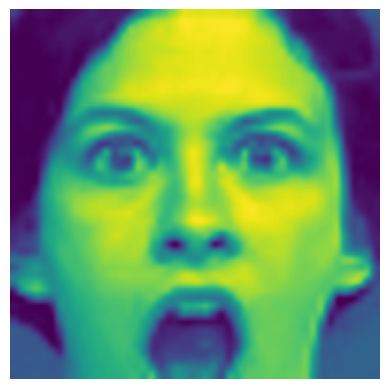

In [18]:
print("The shape of the images list is = "+str(np.shape(images)))
print("The size of the images list is = "+str(np.size(images)))
print("Labels contains these Y0 values " + str(labels))


i=980 #set the desired i value to access the image from 0 to 49222656
plt.imshow(images[i])
plt.axis('off')  # Hide axis labels and ticks
plt.show()

## Reshape the images and label matrix as necessary

In [19]:
images = np.array(images).reshape(224*224,981)
labels = np.array(labels).reshape(7,981)
print(np.size(images[0]))
print(np.size(labels[0]))


981
981


## Initialise W and b for every node of each layer

In [20]:
def initialize_parameters(layers):
    parameters = {"W1":0, "b1":0, "W2":0, "b2":0, "W3":0, "b3":0, "W4":0, "b4":0}  
    L = len(layers)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random((layers[l],layers[l-1]))
        parameters['b' + str(l)] = np.zeros((layers[l],1))
    
    return parameters
    

## The Activation Fuctions

In [21]:
def sigmoid(Z):
    a = 1/np.sum(1,np.exp(-Z))
    return a

def relu(Z):
    a = np.max(0,Z)
    return a

## Propagate forward

In [22]:
def forward_propagation(images,parameters):
    
    W1, b1, W2, b2, W3, b3, W4, b4 = parameters
    
    Z1 = np.sum(np.dot(W1,images),b1)
    A1 = relu(Z1)
    Z2 = np.sum(np.dot(W2,A1),b2)
    A2 = relu(Z2)
    Z3 = np.sum(np.dot(W3,A2),b3)
    A3 = relu(Z3)
    Z4 = np.sum(np.dot(W4,A3),b4)
    A4 = sigmoid(Z4)
    
    cache =  A4, A3, W4
    
    return A4,cache


## Loss Function

In [31]:
def compute_loss(A4,labels):
    
    m = np.size(labels[0])
    cost = np.sum(-(np.multiply(labels,np.log(A4))+np.multiply((1-labels),np.log(1-A4))))/m
    
    return cost

## Gradient Decent

In [27]:
def backward_propagation(images, labels, cache):
    
    A4, A_prev, W = cache
    m=images.shape[0]
    dZ = np.sum(labels-A4)
    dW = np.dot(dZ,A_prev.T)/m
    db = np.sum(dZ,axis=1,keepdims=True)/m #sum by the rows of dZ with keepdims=True
    dA_prev = np.dot(W.T,dZ)
    grads = dZ, dW, db, dA_prev 
    return grads

## Update Parameters

In [25]:
def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters)/2
    for l in range(1,L):
        parameters["W"+str(l)]=parameters["W"+str(l)]-learning_rate*grads["dw"+str(l)]
        parameters["b"+str(l)]=parameters["b"+str(l)]-learning_rate*grads["db"+str(l)]
    return parameters

## Combine all the functions to create a working model

In [26]:
def predictor(images, labels, learning_rate = 0.01):
    grads = {}
    layers = [np.size(images[0]),10,10,10,np.size(labels[0])]
    
    # Initialse w and b
    parameters=initialize_parameters(layers)
    
    # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
    A4, cache = forward_propagation(images, parameters)
        
    # Loss
    cost = compute_loss(A4, labels)

    # Backward propagation.
    grads = backward_propagation(images, labels, cache)
        
    # Update parameters.
    parameters = update_parameters(parameters, grads, learning_rate)
               
    # plot the loss
    plt.plot(cost)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters 

In [32]:
predictor(images, labels, learning_rate = 0.01)


TypeError: 'module' object is not callable